
#### Build a Recurrent Neural Network (RNN) based classifier that deciphers whether the sentiment of a movie review is positive or negative.

#### Dataset – ‘imdb’ dataset comes prepackaged with the keras.datasets module; to import the dataset use: from keras.datasets import imdb


### Reference :-

https://github.com/keras-team/keras/issues/6425

https://www.youtube.com/watch?v=TIJEExt-bp8




### Importing Necessary Libraries

In [42]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


In [2]:
# Checking the tensorflow version

tf.__version__

'2.5.0'

### Mounting Google Drive

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the dataset and splitting the data into train and test set

In [4]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words = 20000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

## Data Preprocessing

### Checking the raw data [ Word Embeded ]

In [5]:
print(X_train[1])

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 10156, 4, 1153, 9, 194, 775, 7, 8255, 11596, 349, 2637, 148, 605, 15358, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


In [6]:
print(Y_train[1])

0


### Decoding the embeded vector into English Language

In [7]:
word_index = imdb.get_word_index()
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


#### Checking the first review

In [8]:
decode_review(X_train[1])

"<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

Checking Max and Min length of review in train and test data

In [9]:
max_len_train = max([len(i) for i in X_train])
print('Maximum length of review in training dataset is :', max_len_train)

Maximum length of review in training dataset is : 2494


In [10]:
max_len_test = max([len(i) for i in X_test])
print('Maximum length of review in testing dataset is :', max_len_test)

Maximum length of review in testing dataset is : 2315


In [ ]:
min_len_train = min([len(i) for i in X_train])
print('Minimum length of review in training dataset is :', min_len_train)

In [12]:
min_len_test = min([len(i) for i in X_test])
print('Minimum length of review in testing dataset is :', min_len_test)

Minimum length of review in testing dataset is : 7


### Padding the test and train data to have 200 maximum length. The shorter reviews will be padded with the word 'the'

In [13]:
word_index['the']
X_train = pad_sequences(X_train, value = word_index['the'], padding= 'post', maxlen = 200)
X_test = pad_sequences(X_test, value = word_index['the'], padding= 'post', maxlen = 200)

In [14]:
X_train.shape

(25000, 200)

In [15]:
X_test.shape

(25000, 200)

### Hyperparameters

In [16]:
vocab_size = 20000
embeded_size = 32
lstm_unit = 60
batch = 16
e = 10

### Building the RNN ( LSTM ) Model

In [17]:
model = Sequential()

# Adding the Embedding Layer

model.add(Embedding(vocab_size, embeded_size, input_shape = (X_train.shape[1],)))

# Adding the first LSTM layer with Dropout

model.add(LSTM(units = lstm_unit, return_sequences = True))
model.add(Dropout(0.2))

# Adding the first LSTM layer with Dropout

model.add(LSTM(units = lstm_unit, return_sequences = True))
model.add(Dropout(0.2))

# Adding the second LSTM layer with Dropout

model.add(LSTM(units = lstm_unit))
model.add(Dropout(0.2))

# Adding the output dense layer

model.add(Dense(units=1, activation='sigmoid'))

### Compiling the model

In [18]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Model Summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 200, 60)           22320     
_________________________________________________________________
dropout (Dropout)            (None, 200, 60)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 60)           29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0

### Training the model

In [20]:
history = model.fit(X_train, Y_train, epochs = e, batch_size= batch, validation_data=(X_test, Y_test))

Epoch 1/10
1563/1563 [==============================] - 63s 34ms/step - loss: 0.6870 - accuracy: 0.5265 - val_loss: 0.6831 - val_accuracy: 0.5322
Epoch 2/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.6706 - accuracy: 0.5736 - val_loss: 0.6766 - val_accuracy: 0.5692
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.6412 - accuracy: 0.6245 - val_loss: 0.6569 - val_accuracy: 0.5530
Epoch 4/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.5076 - accuracy: 0.7543 - val_loss: 0.3916 - val_accuracy: 0.8297
Epoch 5/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.3379 - accuracy: 0.8671 - val_loss: 0.4295 - val_accuracy: 0.8103
Epoch 6/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.2643 - accuracy: 0.8980 - val_loss: 0.3464 - val_accuracy: 0.8662
Epoch 7/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.2072 - accuracy: 0.9244 - val_loss: 0.3286 -

Plotting Model Accuracy

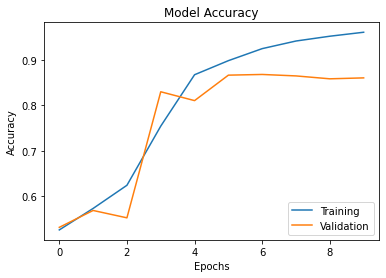

In [21]:
epoch_range = range(0,e)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Plotting the Loss

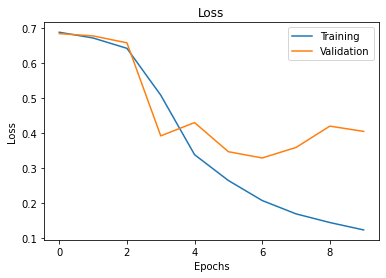

In [22]:
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Predicting the first two review in test dataset

In [23]:
r1 = model.predict(np.expand_dims(X_test[0], axis = 0))

In [24]:
r1

array([[0.13778585]], dtype=float32)

The value 0.137 is less than 0.5. This means that its a negative review. Validating the actual review

In [25]:
decode_review(X_test[0])

"<START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the"

In [26]:
r2 = model.predict(np.expand_dims(X_test[1], axis = 0))

In [27]:
r2

array([[0.9981079]], dtype=float32)

The value 0.998 is more than 0.5. This means that its a positive review. Validating the actual review

In [28]:
decode_review(X_test[1])

"psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the <UNK> moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual repression and desperation be patient <UNK> up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to elicit a strong emotional response from the viewer if you want to see an unusual film some 

#### Predicting all the test reviews

In [29]:
predcited_review = model.predict(X_test)

In [30]:
predcited_review

array([[0.1377859 ],
       [0.9981079 ],
       [0.95245105],
       ...,
       [0.0295311 ],
       [0.02428957],
       [0.97219115]], dtype=float32)

In [31]:
scaled_predict_review = np.asarray(predcited_review)
scaled_predict_review = scaled_predict_review.flatten()

Creating a new array of predicted value to compare with the actual value.
Any value greater than equal to 0.5 will be treated as '1' and any value less than 0.5 will be treated as '0'

In [32]:
for i in range(len(scaled_predict_review)):
  if (scaled_predict_review[i] >= 0.5):
    scaled_predict_review[i] = 1
  else:
    scaled_predict_review[i] = 0

### Visualize the prediction

In [75]:
# Using the first 100 reviews to compare

actual = [None]*100
predicted = [None]*100
for j in range(0,100):
  actual[j] = Y_test[j]
  predicted[j] = scaled_predict_review[j]

The prediction is compared as side by side bar graphs.

In [83]:
figure(figsize=(100, 50), dpi=200)
plt.rcParams.update({'font.size': 40})
plt.bar(np.arange(len(actual))-0.2,actual, width=0.4, label="Actual Review", align="center")
plt.bar(np.arange(len(predicted))+0.2,predicted, width=0.4, label="Predicted Review", align="center")
plt.xlabel('Review')
plt.ylabel("Sentiment ( 1 = 'Positive', 0 = 'Negative')")
plt.legend()
plt.show()

### Summary

We build a recurrent neural network-based classifier that deciphers whether the sentiment of a movie is positive or negative. In order to achieve this, we download the dataset from keras module ‘imdb’. The dataset is split into train and test subset. We first check the raw data in the dataset which is already ‘word embeded’ and are in form of array of word indexes. Then we decode a review to view the actual content in English language. Then we determine the maximum and minimum length of words in the review for the training dataset and test dataset. In the next step we pad each review to have a maximum length of 200 words. The reviews less than 200 words will be padded with the word ‘the’. Then we build the RNN neural network. We first add an Embedding layer and then three LSTM layers along with a Dropout layer. The output layer is a Dense Layer with a ‘sigmoid’ activation function. The model was then compiled and trained by tweeking various hyperparameters. Finally, the best result was achieved with vocab size as 20000, embed size as 32, LSTM units as 60, batch size as 16 and epoch as 10. There are a total of 720461 trainable parameters.

Training Accuracy – 96.03% , 
Validation Accuracy – 86.02%

The Model Accuracy and Loss was visualized for each epoch. Then we try to manually predict the first two test reviews and checked the actual review by decoding it. All the test reviews were then predicted. The first 100 reviews were compared with the actual prediction in form of side by side bar graphs. The ‘1’ represents positive review and ‘0’ represents negative review. The overall performance of the model was satisfactory
